The train set (train.csv) consists of 42000 images of a handwritten digit. Each image is composed of 28 pixels in height and 28 pixels in width. To each pixel is associated an integer between 0 and 255 which represents the brighness of the pixel. 

The train set is organized into a matrix with 42000 rows and 785 columns. 

$\bullet$ The row $i$ corresponds to the training example $i$.

$\bullet$ The first column, denoted $\textit{label}$, corresponds to the integer drawn by the user. 

$\bullet$ The remaining 784 columns describe the value of each pixel.

$\bullet$ Notice that the columns are labeled by $\textit{pixelx}$. To locate the pixel x on the image, it is useful to think of the image as a $28\times 28$ matrix of pixels. Decomposing $x = 28i+j$, pixelx is located on the row $i$ and column $j$ of the image, where $i,j=0,\dots,27$.


In [1]:
import os
import pandas as pd

train_data = pd.read_csv(os.path.join("/Users/julien/digit-recognizer", "train.csv"))
test_data = pd.read_csv(os.path.join("/Users/julien/digit-recognizer", "test.csv"))

print(train_data.shape)
print(train_data.head())
print(test_data.shape)

(42000, 785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0      

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

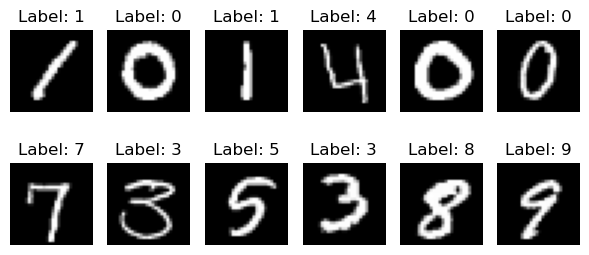

In [3]:
import matplotlib.pyplot as plt

# Set up a grid of 2 rows x 6 columns
fig, axes = plt.subplots(2, 6, figsize=(6, 3))

# Loop through the first 10 images
for i, ax in enumerate(axes.flat):
    sample_image = train_data.iloc[i, 1:].values.reshape(28, 28)  # Reshape the pixels to 28x28
    ax.imshow(sample_image, cmap='gray')  # Plot the image by mapping each pixel value to a corresponding color on a grayscale.
    ax.set_title(f"Label: {train_data.iloc[i, 0]}") 
    ax.axis("off")  

plt.tight_layout()
plt.show()

We now aim to split the training set into a training+validation set. Moreover, to have a better accuracy on the final predictions, we implement a data augmentation on the training set by randomly rotating, flipping images and erasing pixels. We reshape the pixels so that their value is a rational number between 0 and 1.

In [9]:
batch_size_train = 64
batch_size_val = 64
rotations_degree = 15
learning_rate = 0.001
num_epochs = 15

In [10]:
# Extract images and labels
labels = torch.tensor(train_data.iloc[:, 0].values, dtype=torch.long)  
images = train_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28).astype(np.uint8)/255.0  
images = torch.tensor(images, dtype=torch.float32)  

# Define data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=rotations_degree),
    #transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    # transforms.RandomHorizontalFlip()
])

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)  
        return image, self.labels[idx]

# Create a dataset without augmentation first
full_dataset = AugmentedDataset(images, labels, transform=None)

# Split into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])  

# Now wrap train_dataset with augmentation
train_dataset = AugmentedDataset(images[train_dataset.indices], labels[train_dataset.indices], transform=train_transform)
val_dataset = AugmentedDataset(images[val_dataset.indices], labels[val_dataset.indices], transform=None)  # No augmentation

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Training samples: 33600, Validation samples: 8400


In [11]:
# We now create a class which inherits the properties of nn.Module.
# This class will define the layers and operations the model will use.

class DigitModel(nn.Module):
    def __init__(self):
        super(DigitModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128*3*3, 128)  
        self.dropout1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(64, 10)
        

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        #x = self.fc2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

We now define the function evaluate, which evaluates the model on the validation set. For memory purposes, it is more convenient to evaluate on mini-batches.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitModel().to(device)

# We choose the CrossEntropyLoss function which measures how far from the truth the predictions are.
criterion = nn.CrossEntropyLoss()
# We choose the Adam optimizer to find weights which minimize the loss function.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Every 2 epochs, we multiply the learning rate of the Adam optimizer by 0.5
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

def evaluate(model, val_loader, criterion):
    model.eval()  # Set model to evaluation mode (disables dropout & batch norm updates)
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation for validation (faster & saves memory)
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU if available
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)  # Compute average loss
    val_acc = 100 * correct / total  # Compute accuracy
    return val_loss, val_acc

We now train the model. The weights are updated at each new batch. Once we run through the whole training set (an epoch), we print the train loss and we evaluate the model on the validation set.

Epoch [1/15] | Train Acc: 91.12% | Val Acc: 96.93% | Time: 48.29 sec
Epoch [2/15] | Train Acc: 97.06% | Val Acc: 97.76% | Time: 50.11 sec
Epoch [3/15] | Train Acc: 98.08% | Val Acc: 98.93% | Time: 49.45 sec
Epoch [4/15] | Train Acc: 98.48% | Val Acc: 98.87% | Time: 49.61 sec
Epoch [5/15] | Train Acc: 98.83% | Val Acc: 99.15% | Time: 54.22 sec
Epoch [6/15] | Train Acc: 98.93% | Val Acc: 98.85% | Time: 86.07 sec
Epoch [7/15] | Train Acc: 99.04% | Val Acc: 99.26% | Time: 59.86 sec
Epoch [8/15] | Train Acc: 99.15% | Val Acc: 99.27% | Time: 52.84 sec
Epoch [9/15] | Train Acc: 99.20% | Val Acc: 99.35% | Time: 50.22 sec
Epoch [10/15] | Train Acc: 99.28% | Val Acc: 99.33% | Time: 49.99 sec
Epoch [11/15] | Train Acc: 99.29% | Val Acc: 99.35% | Time: 49.93 sec
Epoch [12/15] | Train Acc: 99.35% | Val Acc: 99.39% | Time: 49.94 sec
Epoch [13/15] | Train Acc: 99.35% | Val Acc: 99.39% | Time: 50.01 sec
Epoch [14/15] | Train Acc: 99.38% | Val Acc: 99.36% | Time: 50.15 sec
Epoch [15/15] | Train Acc: 99

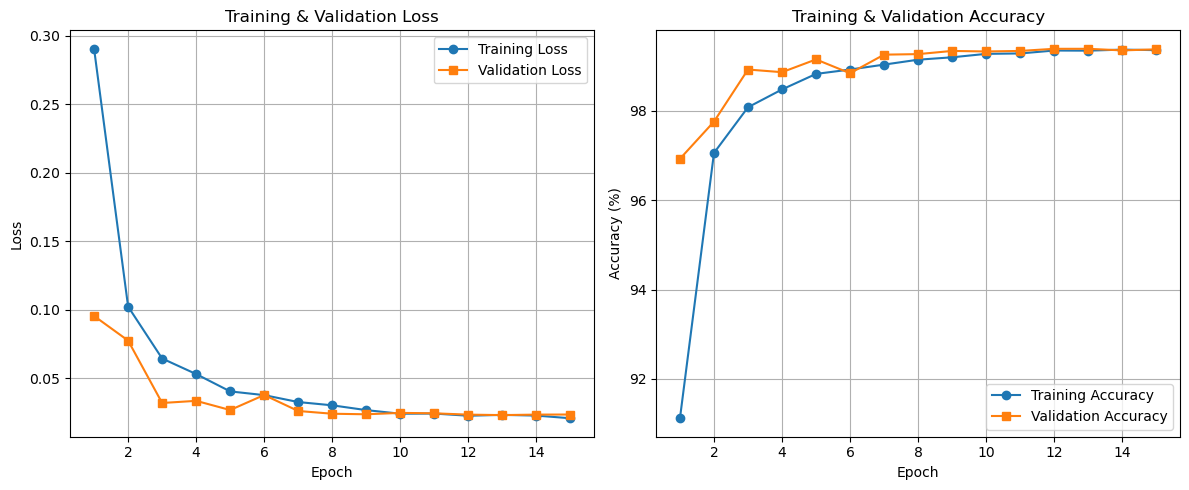

In [13]:
import time

train_losses = []
val_losses = []

train_accs = []
val_accs = []

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move batch to GPU

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    end_time = time.time()
    
    epoch_time = end_time - start_time
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Time: {epoch_time:.2f} sec")
    
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), val_accs, label='Validation Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
test_images = torch.tensor(test_data.values.reshape(-1, 1, 28, 28), dtype=torch.float32)/255.0
test_loader = DataLoader(test_images, batch_size=64, shuffle=False)

model.eval()  # Set model to evaluation mode
predictions = []

with torch.no_grad():  # No gradients needed during inference
    for images in test_loader:
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        predictions.extend(predicted.cpu().numpy())  # Store predictions

submission = pd.DataFrame({'ImageId': np.arange(1, len(predictions) + 1), 'Label': predictions})
submission.to_csv('submission.csv', index=False)

print("Submission file saved as submission.csv")

# 